In [40]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install -q --upgrade git+https://github.com/FloorToxopeus/TM10007_ML_Project.git

from worcgist.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Missing/zero values
columns_with_nulls = data.columns[data.isnull().any()]
columns_with_missing_values = data.columns[data.isna().any()]




The number of samples: 246
The number of columns: 494


In [50]:
# General packages
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy import interp
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import make_pipeline

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

# Hyperparamters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Visualisation
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from tabulate import tabulate
import matplotlib.pyplot as plt
import time

In [42]:
# Cleaning dataset
data['label'] = data['label'].map({'GIST': 1, 'non-GIST': 0})
cleaning = data.reset_index()
tf = cleaning.iloc[:,1]
clean_data = cleaning.drop(['ID', 'label'], axis='columns')
b = tf.to_numpy()
a = clean_data.to_numpy()

constant_features_idx = np.where(np.std(a, axis=0) == 0)[0]         # Wel of niet constanten eruit halen?
a = np.delete(a, constant_features_idx, axis=1)

In [43]:
# Split in designset en testset (90%, 10%)
x_design, x_test, y_design, y_test = model_selection.train_test_split(a, b, test_size=0.1, stratify=b)

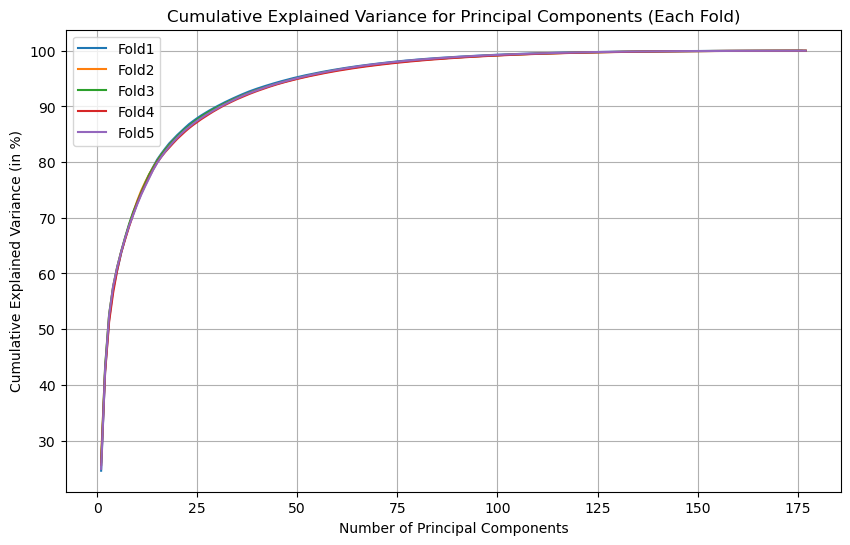

In [44]:
# Initialize a figure to plot the cumulative explained variance for each fold
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

plt.figure(figsize=(10, 6))

# Loop over each fold
for i, (train, validation) in enumerate(cv.split(x_design, y_design)):
    # Scaling
    scaler = preprocessing.MinMaxScaler()
    x_train = scaler.fit_transform(x_design[train])

    # PCA
    pca_p = PCA()
    pca_p.fit(x_train)

    # Calculate cumulative explained variance
    explained_variance = pca_p.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance) * 100

    # Plot the cumulative explained variance for this fold
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, label=f'Fold{i+1}')

plt.title('Cumulative Explained Variance for Principal Components (Each Fold)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (in %)')
# plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.legend()
plt.show()


In [45]:
# # Hyperparameters
# # Knn
# parameters_knn = {'n_neighbors': list(range(1, 26, 2)), 'weights': ['uniform','distance']}
# clf_knn = KNeighborsClassifier()
# para_knn = RandomizedSearchCV(clf_knn, parameters_knn,  error_score='raise', cv=5)                    ################################

# # RFC
# parameters_rf = {'max_depth':[3,5,10,None], 'n_estimators':[10,100,200],
#               'max_features':[1,3,5,7],
#               'min_samples_leaf':[1,2,3],
#               'min_samples_split':[2,3,4]}                                                            ################################
# clf_rf = RandomForestClassifier()
# para_rf = RandomizedSearchCV(clf_rf, parameters_rf,  error_score='raise', cv=5)                       ################################

# # SVM
# parameters_svm = {'C': [0.1, 1, 10, 100],                                                                  ################################
#                   'kernel': ['linear','rbf', 'poly', 'sigmoid'],                                               ################################
#                   'gamma': ['scale', 'auto']}
# clf_svm = svm.SVC()
# para_svm = RandomizedSearchCV(clf_svm, parameters_svm,  error_score='raise', cv=5)                    ################################

# # Feature selection

# features = [RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10), SelectKBest(score_func=f_classif, k=10), PCA(n_components=0.95)]          # Moet floor nog aanpassen
# feat_names = ['RFE', 'ANOVA','PCA']

# # Classifiers
# clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svm.SVC()]
# #
# clf_names = ['KNN', 'RdmFor','SVM']
# #

# # Define cross-validation
# cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)                                       ################################

# # Initialize dictionary to store models
# models = {}
# accuracies = {}
# precisions = {}
# recalls = {}
# f1_scores = {}
# fprs = {}
# tprs = {}
# thresholds = {}
# aucs = {}
# # For each feature and classifier
# for feat, feat_name in zip(features, feat_names):
#   for clf, clf_name in zip(clsfs, clf_names):

#     # For each fold
#     for i, (train, validation) in enumerate(cv.split(x_design, y_design)):

#       start_time = time.time()  # capture the start time

#       # Create a unique name for each model
#       model_name = f"{feat_name}_{clf_name}_fold{i+1}"
#       print(f'Now training {model_name}')

#       # Scaling
#       scaler = preprocessing.MinMaxScaler()                                                           ################################
#       x_train = scaler.fit_transform(x_design[train],y_design[train])
#       x_validation= scaler.fit_transform(x_design[validation],y_design[validation])
#       y_train = y_design[train]
#       y_validation = y_design[validation]

#       # KNeighbours
#       if clf_name == 'KNN':
#         best_knn = para_knn.fit(x_train,y_train)
#         optim_nn = best_knn.best_estimator_.get_params()
#         classif = KNeighborsClassifier(n_neighbors=optim_nn['n_neighbors'],
#                                        weights=optim_nn['weights'])
#       # RandomForest
#       if clf_name == 'RdmFor':
#         best_rf = para_rf.fit(x_train,y_train)
#         optim_rf = best_rf.best_estimator_.get_params()
#         classif = RandomForestClassifier(max_depth=optim_rf['max_depth'],
#                                          n_estimators=optim_rf['n_estimators'],
#                                          max_features=optim_rf['max_features'],
#                                          min_samples_leaf=optim_rf['min_samples_leaf'],
#                                          min_samples_split=optim_rf['min_samples_split'])
#       # SVM
#       if clf_name == 'SVM':
#         best_svm = para_svm.fit(x_train,y_train)
#         optim_svm = best_svm.best_estimator_.get_params()
#         classif = svm.SVC(C=optim_svm['C'],
#                           kernel=optim_svm['kernel'],
#                           gamma=optim_svm['gamma'], probability=True)


#       # Make pipeline
#       pipe = make_pipeline(feat, classif)

#       # Fit model
#       pipe.fit(x_train, y_train)                                                                        ################################

#       # Save model
#       models[model_name] = pipe

#       probas_ = pipe.predict_proba(x_validation)

#       # Compute ROC curve and area under the curve
#       fpr, tpr, threshold = roc_curve(y_validation, probas_[:, 1])
#       roc_auc = auc(fpr, tpr)

#       y_pred = pipe.predict(x_validation)

#       #Compute metrics
#       accuracy = accuracy_score(y_validation, y_pred)
#       precision = precision_score(y_validation, y_pred, average='macro')
#       recall = recall_score(y_validation, y_pred, average='macro')
#       f1 = f1_score(y_validation, y_pred, average='macro')

#       # Save metrics
#       accuracies[model_name] = accuracy
#       precisions[model_name] = precision
#       recalls[model_name] = recall
#       f1_scores[model_name] = f1
#       fprs[model_name] = fpr
#       tprs[model_name] = tpr
#       thresholds[model_name] = threshold
#       aucs[model_name] = roc_auc

#       end_time = time.time()  # capture the end time
#       runtime = (end_time - start_time)/60  # calculate the runtime

#       print(f'Training completed of {model_name} in {runtime:.2f} minutes')


Now training RFE_KNN_fold1
Training completed of RFE_KNN_fold1 in 0.29 minutes
Now training RFE_KNN_fold2
Training completed of RFE_KNN_fold2 in 0.23 minutes
Now training RFE_KNN_fold3
Training completed of RFE_KNN_fold3 in 0.25 minutes
Now training RFE_KNN_fold4
Training completed of RFE_KNN_fold4 in 0.23 minutes
Now training RFE_KNN_fold5
Training completed of RFE_KNN_fold5 in 0.25 minutes
Now training RFE_RdmFor_fold1
Training completed of RFE_RdmFor_fold1 in 0.36 minutes
Now training RFE_RdmFor_fold2
Training completed of RFE_RdmFor_fold2 in 0.31 minutes
Now training RFE_RdmFor_fold3
Training completed of RFE_RdmFor_fold3 in 0.31 minutes
Now training RFE_RdmFor_fold4
Training completed of RFE_RdmFor_fold4 in 0.34 minutes
Now training RFE_RdmFor_fold5
Training completed of RFE_RdmFor_fold5 in 0.32 minutes
Now training RFE_SVM_fold1
Training completed of RFE_SVM_fold1 in 0.27 minutes
Now training RFE_SVM_fold2
Training completed of RFE_SVM_fold2 in 0.21 minutes
Now training RFE_SVM_f

c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training completed of RFE_SVM_fold3 in 0.23 minutes
Now training RFE_SVM_fold4
Training completed of RFE_SVM_fold4 in 0.22 minutes
Now training RFE_SVM_fold5
Training completed of RFE_SVM_fold5 in 0.24 minutes
Now training ANOVA_KNN_fold1


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_KNN_fold1 in 0.02 minutes
Now training ANOVA_KNN_fold2


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 76  82  83  93 104] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_KNN_fold2 in 0.02 minutes
Now training ANOVA_KNN_fold3


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_KNN_fold3 in 0.02 minutes
Now training ANOVA_KNN_fold4


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_KNN_fold4 in 0.02 minutes
Now training ANOVA_KNN_fold5


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_KNN_fold5 in 0.02 minutes
Now training ANOVA_RdmFor_fold1


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_RdmFor_fold1 in 0.08 minutes
Now training ANOVA_RdmFor_fold2


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 76  82  83  93 104] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_RdmFor_fold2 in 0.07 minutes
Now training ANOVA_RdmFor_fold3


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_RdmFor_fold3 in 0.09 minutes
Now training ANOVA_RdmFor_fold4


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_RdmFor_fold4 in 0.09 minutes
Now training ANOVA_RdmFor_fold5


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_RdmFor_fold5 in 0.09 minutes
Now training ANOVA_SVM_fold1
Training completed of ANOVA_SVM_fold1 in 0.00 minutes
Now training ANOVA_SVM_fold2


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 76  82  83  93 104] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_SVM_fold2 in 0.00 minutes
Now training ANOVA_SVM_fold3
Training completed of ANOVA_SVM_fold3 in 0.00 minutes
Now training ANOVA_SVM_fold4


c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [82] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\pb_va\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training completed of ANOVA_SVM_fold4 in 0.00 minutes
Now training ANOVA_SVM_fold5
Training completed of ANOVA_SVM_fold5 in 0.00 minutes
Now training PCA_KNN_fold1
Training completed of PCA_KNN_fold1 in 0.02 minutes
Now training PCA_KNN_fold2
Training completed of PCA_KNN_fold2 in 0.02 minutes
Now training PCA_KNN_fold3
Training completed of PCA_KNN_fold3 in 0.02 minutes
Now training PCA_KNN_fold4
Training completed of PCA_KNN_fold4 in 0.02 minutes
Now training PCA_KNN_fold5
Training completed of PCA_KNN_fold5 in 0.02 minutes
Now training PCA_RdmFor_fold1
Training completed of PCA_RdmFor_fold1 in 0.07 minutes
Now training PCA_RdmFor_fold2
Training completed of PCA_RdmFor_fold2 in 0.07 minutes
Now training PCA_RdmFor_fold3
Training completed of PCA_RdmFor_fold3 in 0.09 minutes
Now training PCA_RdmFor_fold4
Training completed of PCA_RdmFor_fold4 in 0.13 minutes
Now training PCA_RdmFor_fold5
Training completed of PCA_RdmFor_fold5 in 0.07 minutes
Now training PCA_SVM_fold1
Training complet

In [ ]:
###################################################################################

# Define cross-validation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)   


# Initialize dictionary to store models
models = {}
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}
fprs = {}
tprs = {}
thresholds = {}
aucs = {}

plt.figure(figsize=(10, 6))

# For each fold
for i, (train, validation) in enumerate(cv.split(x_design, y_design)):

  # Scaling
  scaler = preprocessing.RobustScaler()                                                           ################################
  x_train = scaler.fit_transform(x_design[train],y_design[train])
  x_validation= scaler.fit_transform(x_design[validation],y_design[validation])
  y_train = y_design[train]
  y_validation = y_design[validation]
        
  # PCA
  pca_p = PCA()
  pca_p.fit(x_train)

  # Calculate cumulative explained variance
  explained_variance = pca_p.explained_variance_ratio_
  cumulative_variance = np.cumsum(explained_variance) * 100

  # Plot the cumulative explained variance for this fold
  plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, label=f'Fold{i+1}')
  plt.title('Cumulative Explained Variance for Principal Components (Each Fold)')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance (in %)')
  # plt.xticks(range(1, len(explained_variance) + 1))
  plt.axhline(y=95, color='r', linestyle='--', label='95% Variance')
  plt.xlim(0, 40)
  plt.grid(True)
  plt.legend()
  plt.show() 

  ################################
  # Hyperparameters
  # Knn
  parameters_knn = {'n_neighbors': list(range(1, 26, 2)), 'weights': ['uniform','distance']}
  clf_knn = KNeighborsClassifier()
  para_knn = RandomizedSearchCV(clf_knn, parameters_knn,  error_score='raise', cv=5)                    ################################

  # RFC
  parameters_rf = {'max_depth':[3,5,10,None], 'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[2,3,4]}                                                            ################################
  clf_rf = RandomForestClassifier()
  para_rf = RandomizedSearchCV(clf_rf, parameters_rf,  error_score='raise', cv=5)                       ################################

  # SVM
  parameters_svm = {'C': [1, 10, 100],                                                                  ################################
                  'kernel': ['rbf', 'poly', 'sigmoid'],                                               ################################
                  'gamma': ['scale', 'auto']}
  clf_svm = svm.SVC()
  para_svm = RandomizedSearchCV(clf_svm, parameters_svm,  error_score='raise', cv=5)                    ################################

  # Feature selection

  features = [RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10), SelectKBest(score_func=f_classif, k=10), PCA(n_components=np.argmax(cumulative_variance >= 95) + 1)]          # Moet floor nog aanpassen
  feat_names = ['RFE', 'ANOVA','PCA']

  # Classifiers
  clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svm.SVC()]
  #
  clf_names = ['KNN', 'RdmFor','SVM']


  # For each feature and classifier
  for feat, feat_name in zip(features, feat_names):
    for clf, clf_name in zip(clsfs, clf_names):

      start_time = time.time()  # capture the start time

      #  a unique name for each model
      model_name = f"{feat_name}_{clf_name}_fold{i+1}"
      print(f'Now training {model_name}')
       

      # KNeighbours
      if clf_name == 'KNN':
        best_knn = para_knn.fit(x_train,y_train)
        optim_nn = best_knn.best_estimator_.get_params()
        classif = KNeighborsClassifier(n_neighbors=optim_nn['n_neighbors'],
                                       weights=optim_nn['weights'])
      # RandomForest
      if clf_name == 'RdmFor':
        best_rf = para_rf.fit(x_train,y_train)
        optim_rf = best_rf.best_estimator_.get_params()
        classif = RandomForestClassifier(max_depth=optim_rf['max_depth'],
                                         n_estimators=optim_rf['n_estimators'],
                                         max_features=optim_rf['max_features'],
                                         min_samples_leaf=optim_rf['min_samples_leaf'],
                                         min_samples_split=optim_rf['min_samples_split'])
      # SVM
      if clf_name == 'SVM':
        best_svm = para_svm.fit(x_train,y_train)
        optim_svm = best_svm.best_estimator_.get_params()
        classif = svm.SVC(C=optim_svm['C'],
                          kernel=optim_svm['kernel'],
                          gamma=optim_svm['gamma'], probability=True)


      # Make pipeline
      pipe = make_pipeline(feat, classif)

      # Fit model
      pipe.fit(x_train, y_train)                                                                        ################################

      # Save model
      models[model_name] = pipe

      probas_ = pipe.predict_proba(x_validation)

      # Compute ROC curve and area under the curve
      fpr, tpr, threshold = roc_curve(y_validation, probas_[:, 1])
      roc_auc = auc(fpr, tpr)

      y_pred = pipe.predict(x_validation)

      #Compute metrics
      accuracy = accuracy_score(y_validation, y_pred)
      precision = precision_score(y_validation, y_pred, average='macro')
      recall = recall_score(y_validation, y_pred, average='macro')
      f1 = f1_score(y_validation, y_pred, average='macro')

      # Save metrics
      accuracies[model_name] = accuracy
      precisions[model_name] = precision
      recalls[model_name] = recall
      f1_scores[model_name] = f1
      fprs[model_name] = fpr
      tprs[model_name] = tpr
      thresholds[model_name] = threshold
      aucs[model_name] = roc_auc

      end_time = time.time()  # capture the end time
      runtime = (end_time - start_time)/60  # calculate the runtime

      print(f'Training completed of {model_name} in {runtime:.2f} minutes')

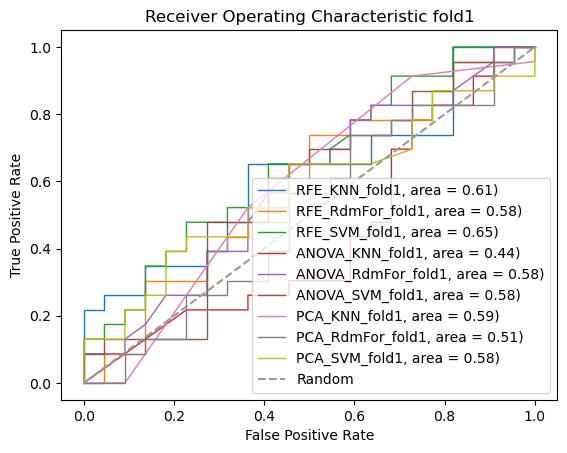

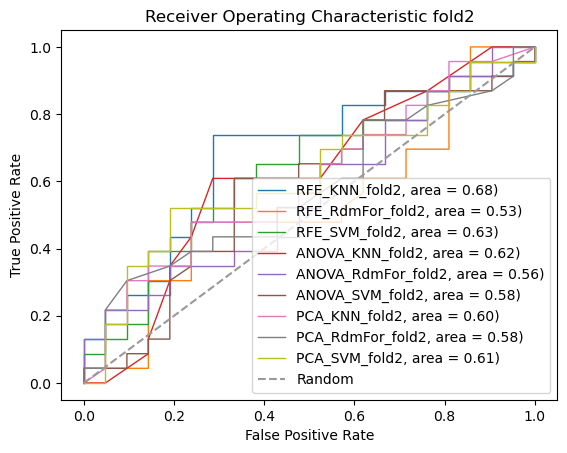

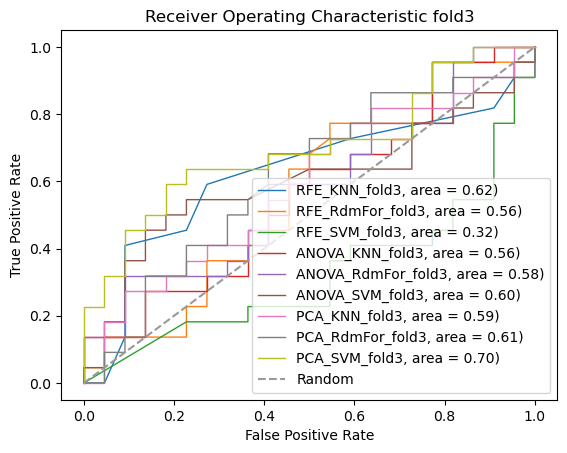

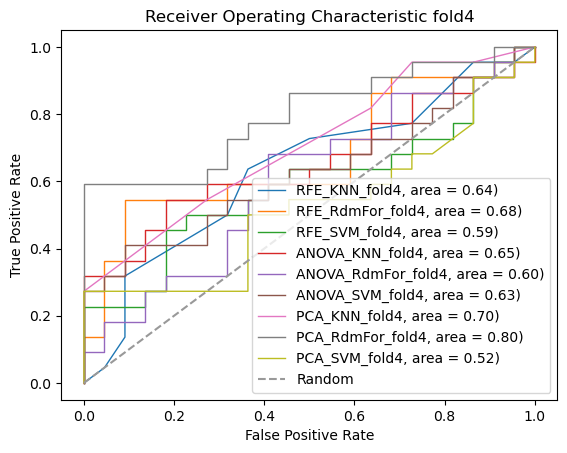

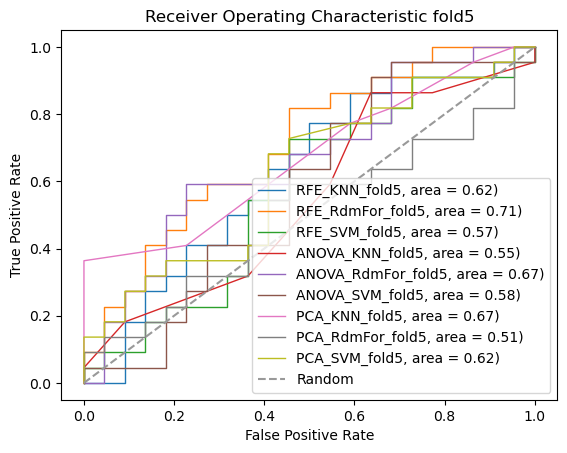

{'RFE_SVM_fold1': 0.6492094861660079, 'RFE_KNN_fold2': 0.6770186335403727, 'PCA_SVM_fold3': 0.6983471074380165, 'PCA_RdmFor_fold4': 0.7975206611570248, 'RFE_RdmFor_fold5': 0.7086776859504132}


In [46]:
## VISUALISATION

# ROC-curves: 5 ROC with 9 graphs
best_comb = {}

# String to look for in the keys
fold_n = ["fold1", "fold2", "fold3", "fold4", "fold5"]
for n in fold_n:
    string_to_find = n
    per_fold = {}
    plt.figure()
    for (tpr_name, tpr), (fpr_name, fpr), (auc_name, auc) in zip(tprs.items(),fprs.items(),aucs.items()):
        if string_to_find in fpr_name and string_to_find in tpr_name and string_to_find in auc_name:
          # Plot ROC curve
          plt.plot(fpr,tpr, lw=1, label=f'{fpr_name}, area = {auc:.2f})')

          per_fold[fpr_name] = auc
    max_auc = max(zip(per_fold.values(), per_fold.keys()))[1]
    best_comb[max_auc] = per_fold[max_auc]

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic '+n)
    plt.legend(loc="lower right")
    plt.show()

print(best_comb)


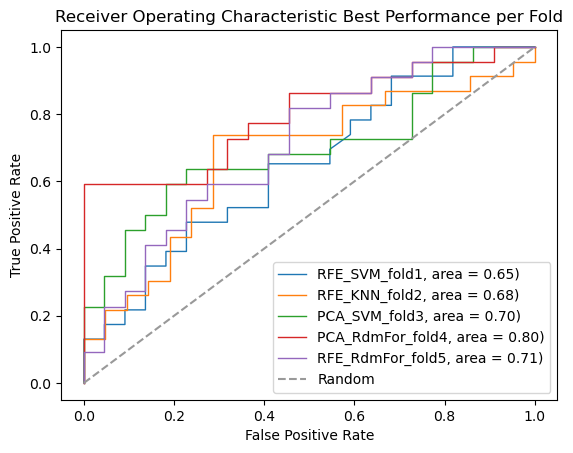

In [47]:
# ROC-curve: 1 ROC met beste van elke fold

# Plot every best ROC per fold
plt.figure()
for best in best_comb:
    string_to_find = best
    for (tpr_name, tpr), (fpr_name, fpr), (auc_name, auc) in zip(tprs.items(),fprs.items(),aucs.items()):
        if string_to_find in fpr_name and string_to_find in tpr_name and string_to_find in auc_name:

            # Plot ROC curve
            plt.plot(fpr,tpr, lw=1, label=f'{fpr_name}, area = {auc:.2f})')

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic Best Performance per Fold')
plt.legend(loc="lower right")
plt.show()

In [55]:
# 5 Tables with best curve per fold

for best in best_comb:
    table = [["Accuracy","Precision","Recall", "f1", "AUC"],
                [accuracies[best], precisions[best], recalls[best],
                         f1_scores[best], aucs[best]]]
    table = tabulate(table, headers='firstrow',tablefmt='fancy_grid')
    print(string_to_find)
    print(table)

RFE_RdmFor_fold5
╒════════════╤═════════════╤══════════╤══════════╤══════════╕
│   Accuracy │   Precision │   Recall │       f1 │      AUC │
╞════════════╪═════════════╪══════════╪══════════╪══════════╡
│   0.577778 │    0.583333 │ 0.574111 │ 0.563998 │ 0.649209 │
╘════════════╧═════════════╧══════════╧══════════╧══════════╛
RFE_RdmFor_fold5
╒════════════╤═════════════╤══════════╤══════════╤══════════╕
│   Accuracy │   Precision │   Recall │       f1 │      AUC │
╞════════════╪═════════════╪══════════╪══════════╪══════════╡
│   0.636364 │    0.642105 │ 0.639752 │ 0.635611 │ 0.677019 │
╘════════════╧═════════════╧══════════╧══════════╧══════════╛
RFE_RdmFor_fold5
╒════════════╤═════════════╤══════════╤══════════╤══════════╕
│   Accuracy │   Precision │   Recall │       f1 │      AUC │
╞════════════╪═════════════╪══════════╪══════════╪══════════╡
│   0.613636 │    0.615789 │ 0.613636 │ 0.611832 │ 0.698347 │
╘════════════╧═════════════╧══════════╧══════════╧══════════╛
RFE_RdmFor_fold5
╒═

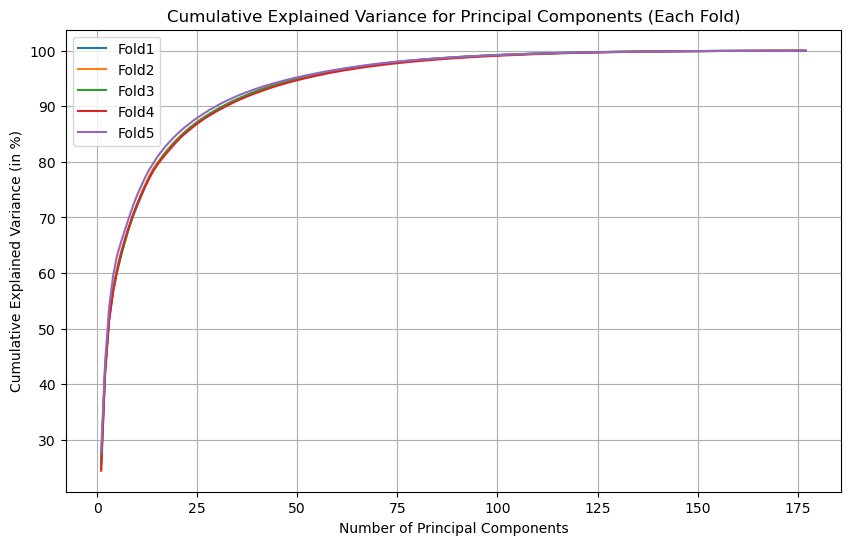

In [ ]:
# Initialize a figure to plot the cumulative explained variance for each fold
plt.figure(figsize=(10, 6))

# Loop over each fold
for i, (train, validation) in enumerate(cv.split(x_design, y_design)):
    # Scaling
    scaler = preprocessing.MinMaxScaler()
    x_train = scaler.fit_transform(x_design[train])

    # PCA
    pca_p = PCA()
    pca_p.fit(x_train)

    # Calculate cumulative explained variance
    explained_variance = pca_p.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance) * 100

    # Plot the cumulative explained variance for this fold
    plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, label=f'Fold{i+1}')

plt.title('Cumulative Explained Variance for Principal Components (Each Fold)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (in %)')
plt.grid(True)
plt.legend()
plt.show()


## Testing

In [ ]:
print(best_comb)

# Scaling
scaler = preprocessing.RobustScaler()                                                           ################################
x_test = scaler.fit_transform(x_test,y_test)

models_final = {}
accuracies_final = {}
precisions_final = {}
recalls_final = {}
f1_scores_final = {}
fprs_final = {}
tprs_final = {}
thresholds_final = {}
aucs_final = {}


for best_name, best in best_comb.items():
    for model_name, model in models.items():
        if best_name in model_name:
            
            #Fit on design set
            model.fit(x_design, y_design)
           
            # Save model
            models_final[model_name] = model

            probas_ = model.predict_proba(x_test)

            fpr, tpr, threshold = roc_curve(y_test, probas_[:, 1])
            rocauc = roc_auc_score(y_test, probas_[:, 1])


            y_pred = model.predict(x_test)

            #Compute metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')

            # Save metrics
            accuracies_final[model_name] = accuracy
            precisions_final[model_name] = precision
            recalls_final[model_name] = recall
            f1_scores_final[model_name] = f1
            fprs_final[model_name] = fpr
            tprs_final[model_name] = tpr
            thresholds_final[model_name] = threshold
            aucs_final[model_name] = rocauc

            start_time = time.time()  # capture the start time

            end_time = time.time()  # capture the end time
            runtime = (end_time - start_time)/60  # calculate the runtime

            print(f'Training completed of {model_name} in {runtime:.2f} minutes')


In [ ]:
for model in models_final:
    table = [["Accuracy","Precision","Recall", "f1", "AUC"],
                        [accuracies[model], precisions[model], recalls[model],
                         f1_scores[model], aucs[model]]]
    table = tabulate(table, headers='firstrow',tablefmt='fancy_grid')
    print(model)
    print(table)

In [ ]:
# ROC-curve: van testset

# Plot every best ROC per fold
plt.figure()
for (tpr_name, tpr), (fpr_name, fpr), (auc_name, auc) in zip(tprs_final.items(),fprs_final.items(),aucs_final.items()):
            
    # Plot ROC curve
    plt.plot(fpr,tpr, lw=1, label=f'{fpr_name}, area = {auc:.2f})')

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic Best Performance per Fold')
plt.legend(loc="lower right")
plt.show()